In [1]:
#From https://github.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/blob/main/Chapter_13.ipynb

import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

2024-01-30 16:10:11,566 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'totalBandwidth'),
                           ('ihave', 'gossipBandwidth'),
                           ('iwant', 'gossipBandwidth'),
                           ('gossipBandwidth', 'totalBandwidth'),
                           ('messageReceived', 'messageBandwidth'),
                           ('messageBandwidth', 'totalBandwidth')
                         ])

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [4]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})#, 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# consolidated = consolidated.diff().dropna()

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
#                   'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
0,1773.489130,8684.0,1193.0,0.0,0.0,0.0,698.0,119.9,2003.2,1014.9,8,6,12,4,8,2,0.25,1.0,0
1,2037.555657,16138.0,2188.0,0.0,0.0,0.0,1032.0,220.0,3705.7,1871.9,8,6,12,4,8,2,0.25,1.0,0
2,1770.802686,13689.0,1874.0,0.0,0.0,0.0,1339.0,188.2,3168.0,1610.9,8,6,12,4,8,2,0.25,1.0,0
3,1765.751992,13750.0,1898.0,0.0,0.0,0.0,963.0,190.9,3164.8,1598.9,8,6,12,4,8,2,0.25,1.0,0
4,1960.033882,13993.0,1930.0,0.0,0.0,2.0,968.0,193.6,3222.4,1629.5,8,6,12,4,8,2,0.25,1.0,0
5,1962.132923,16160.0,2210.0,0.0,0.0,0.0,1283.0,222.1,3724.3,1886.2,8,6,12,4,8,2,0.25,1.0,0
6,1982.278101,13942.0,1926.0,0.0,0.0,0.0,970.0,193.5,3209.4,1621.7,8,6,12,4,8,2,0.25,1.0,0
7,1808.053122,14533.0,2002.0,0.0,0.0,0.0,961.0,200.9,3342.9,1688.7,8,6,12,4,8,2,0.25,1.0,0
8,1996.014559,15959.0,2179.0,0.0,0.0,0.0,1292.0,219.0,3679.9,1865.0,8,6,12,4,8,2,0.25,1.0,0
9,1823.973827,14792.0,2039.0,0.0,0.0,0.0,957.0,204.6,3400.9,1717.1,8,6,12,4,8,2,0.25,1.0,0


In [5]:
#Differenting -> https://medium.com/@nathanvenos/time-series-analysis-in-python-ab582dd803cd

consolidateddiff = consolidated.diff().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidateddiff.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
1,264.066526,7454.0,995.0,0.0,0.0,0.0,334.0,100.1,1702.5,857.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-266.752971,-2449.0,-314.0,0.0,0.0,0.0,307.0,-31.8,-537.7,-261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-5.050694,61.0,24.0,0.0,0.0,0.0,-376.0,2.7,-3.2,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,194.281890,243.0,32.0,0.0,0.0,2.0,5.0,2.7,57.6,30.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.099041,2167.0,280.0,0.0,0.0,-2.0,315.0,28.5,501.9,256.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,20.145178,-2218.0,-284.0,0.0,0.0,0.0,-313.0,-28.6,-514.9,-264.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-174.224979,591.0,76.0,0.0,0.0,0.0,-9.0,7.4,133.5,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,187.961437,1426.0,177.0,0.0,0.0,0.0,331.0,18.1,337.0,176.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-172.040732,-1167.0,-140.0,0.0,0.0,0.0,-335.0,-14.4,-279.0,-147.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-47.302000,-890.0,-129.0,0.0,0.0,0.0,6.0,-12.4,-199.1,-97.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


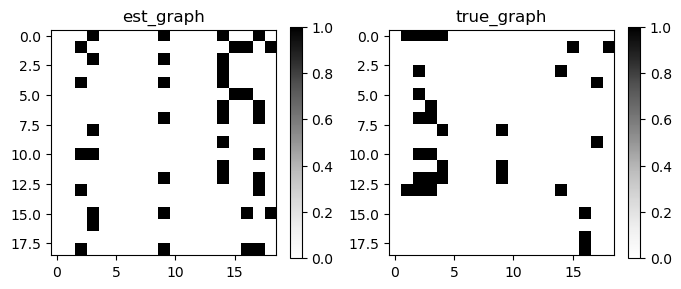

{'fdr': 0.7619, 'tpr': 0.3226, 'fpr': 0.2286, 'shd': 52, 'nnz': 42, 'precision': 0.2381, 'recall': 0.3226, 'F1': 0.274, 'gscore': 0.0}


In [12]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
                            (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
                            (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
                            (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
                            (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
                            (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
                            (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
                            (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
                            (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
                            (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15),(14,4),(16,17),(16,18)])
# priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

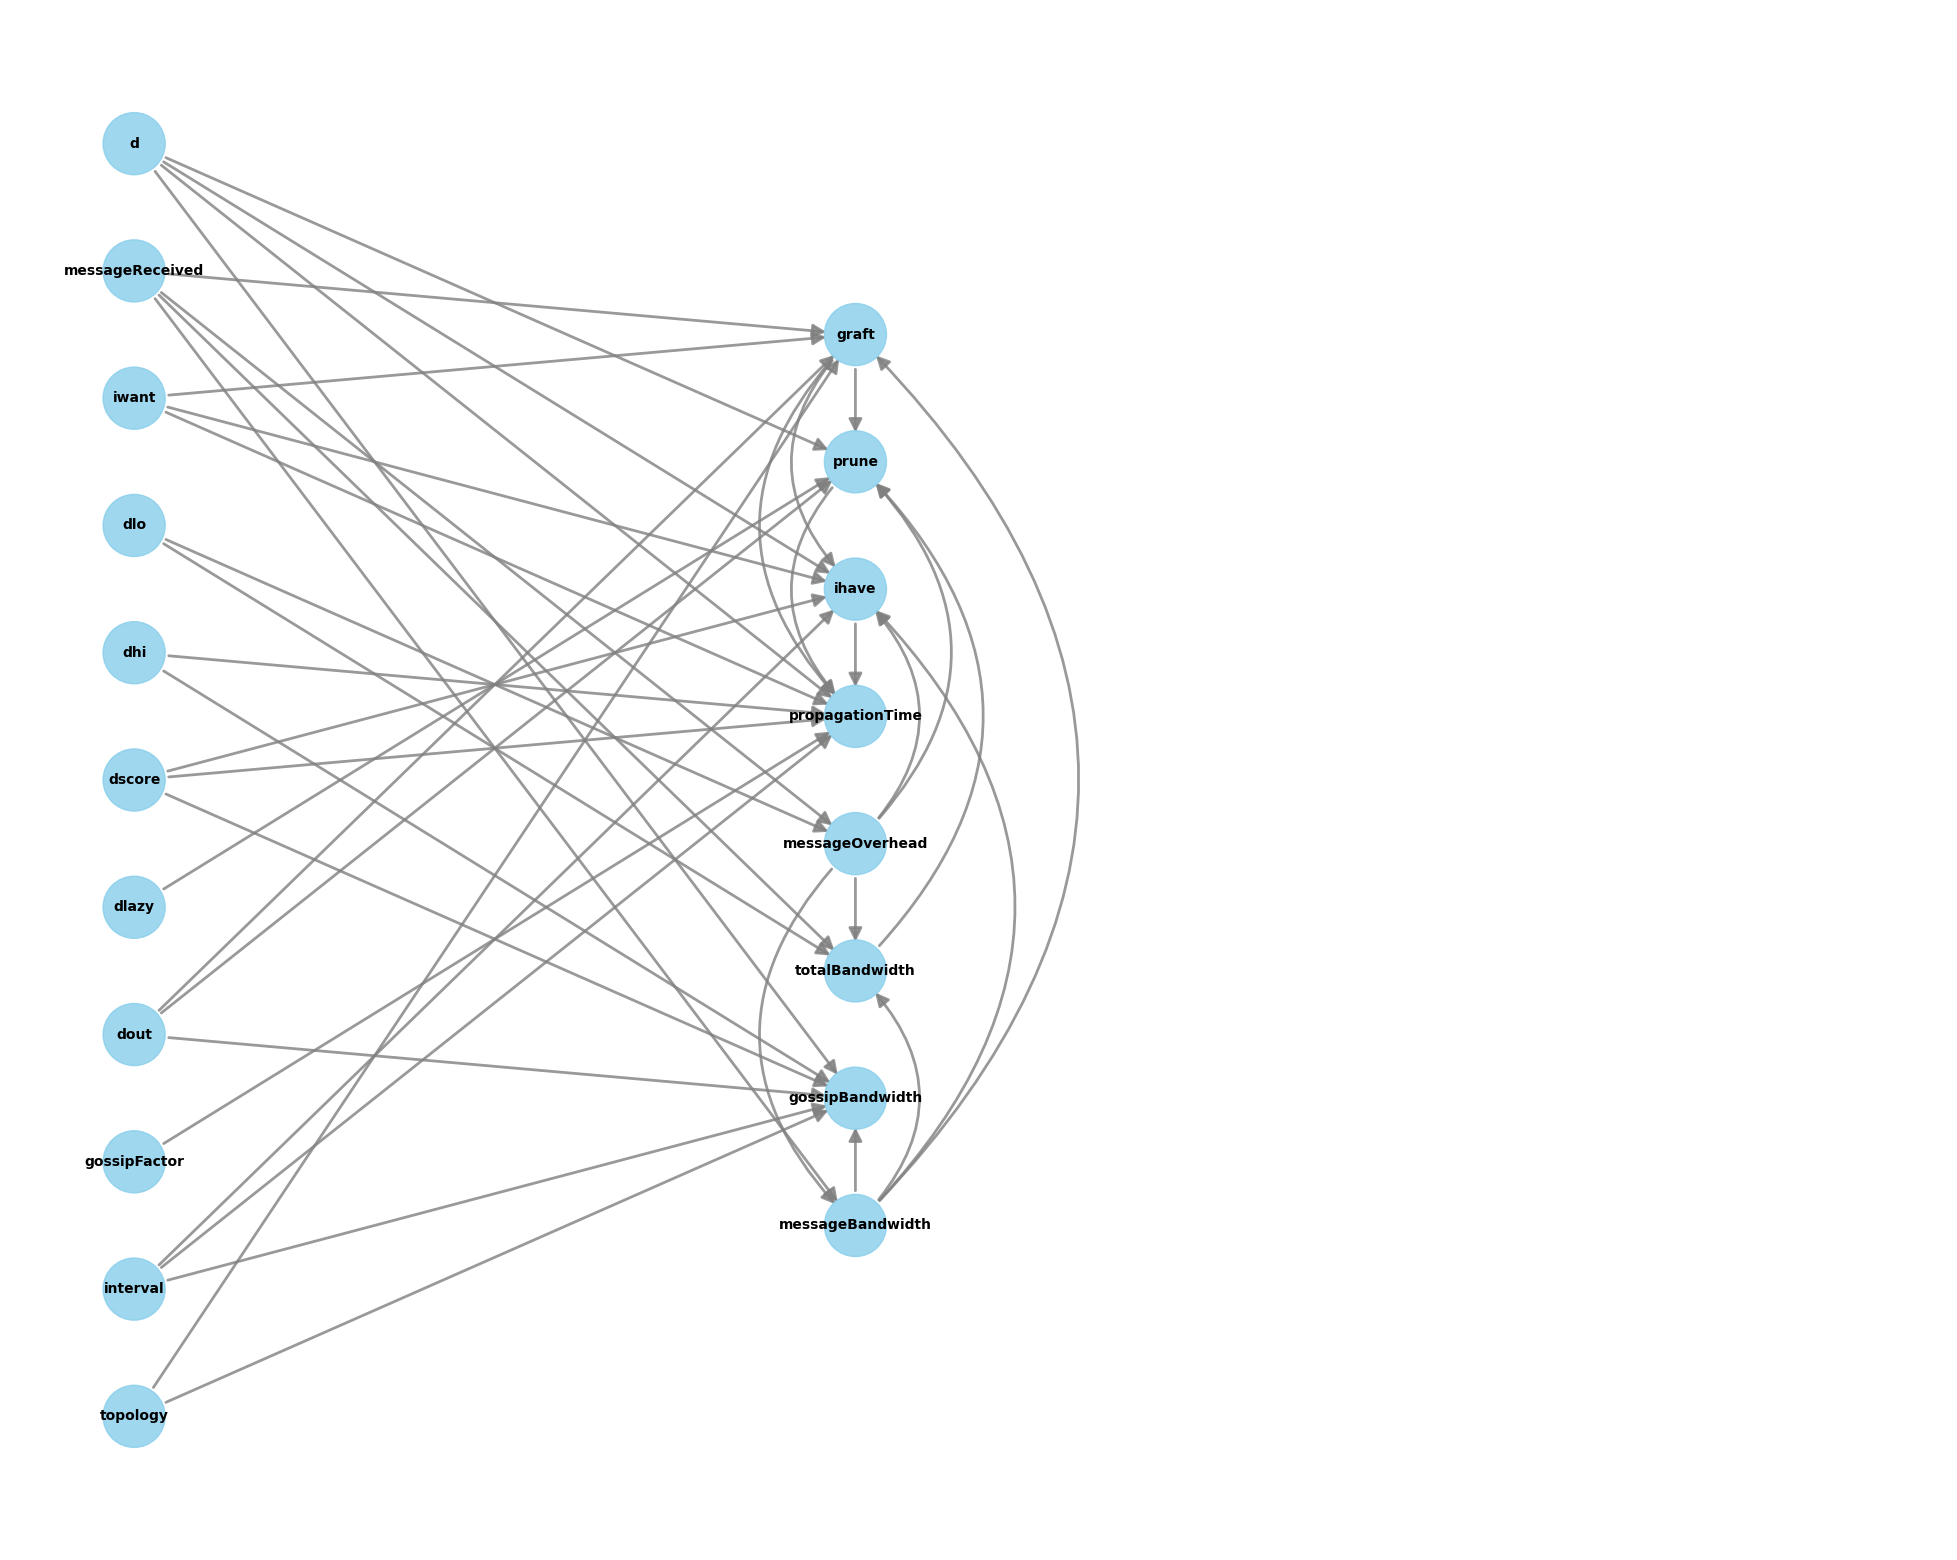

In [13]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'totalBandwidth',
            17:'gossipBandwidth',
            18:'messageBandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [14]:
#Log normalization

# consolidateddiff = consolidated.diff().dropna()
consolidatedLog = consolidated

consolidatedLog['messageReceived'] = np.log(consolidated['messageReceived']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['graft'] = np.log(consolidated['graft']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['prune'] = np.log(consolidated['prune']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['iwant'] = np.log(consolidated['iwant']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['ihave'] = np.log(consolidated['ihave']).replace([np.inf, -np.inf], np.nan)
# consolidatedLog['gossipFactor'] = np.log10(consolidated['gossipFactor'])
consolidatedLog['propagationTime'] = np.log(consolidated['propagationTime']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['messageOverhead'] = np.log(consolidated['messageOverhead']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['totalBandiwdth'] = np.log(consolidated['totalBandwidth']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['gossipBandwidth'] = np.log(consolidated['gossipBandwidth']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['messageBandwidth'] = np.log(consolidated['messageBandwidth']).replace([np.inf, -np.inf], np.nan)

consolidatedLog = consolidatedLog.fillna(0)

X = consolidatedLog[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidatedLog.head(10)


/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology,totalBandiwdth
0,7.480704,9.069238,7.084226,0.0,0.0,0.000000,6.548219,4.786658,2003.2,6.922545,8,6,12,4,8,2,0.25,1.0,0,7.602501
1,7.619506,9.688932,7.690743,0.0,0.0,0.000000,6.939254,5.393628,3705.7,7.534709,8,6,12,4,8,2,0.25,1.0,0,8.217627
2,7.479188,9.524348,7.535830,0.0,0.0,0.000000,7.199678,5.237505,3168.0,7.384548,8,6,12,4,8,2,0.25,1.0,0,8.060856
3,7.476332,9.528794,7.548556,0.0,0.0,0.000000,6.870053,5.251750,3164.8,7.377071,8,6,12,4,8,2,0.25,1.0,0,8.059845
4,7.580717,9.546312,7.565275,0.0,0.0,0.693147,6.875232,5.265794,3222.4,7.396028,8,6,12,4,8,2,0.25,1.0,0,8.077882
5,7.581787,9.690294,7.700748,0.0,0.0,0.000000,7.156956,5.403128,3724.3,7.542320,8,6,12,4,8,2,0.25,1.0,0,8.222634
6,7.592002,9.542661,7.563201,0.0,0.0,0.000000,6.877296,5.265278,3209.4,7.391230,8,6,12,4,8,2,0.25,1.0,0,8.073839
7,7.500006,9.584177,7.601902,0.0,0.0,0.000000,6.867974,5.302807,3342.9,7.431714,8,6,12,4,8,2,0.25,1.0,0,8.114594
8,7.598908,9.677778,7.686621,0.0,0.0,0.000000,7.163947,5.389072,3679.9,7.531016,8,6,12,4,8,2,0.25,1.0,0,8.210641
9,7.508773,9.601842,7.620215,0.0,0.0,0.000000,6.863803,5.321057,3400.9,7.448392,8,6,12,4,8,2,0.25,1.0,0,8.131795


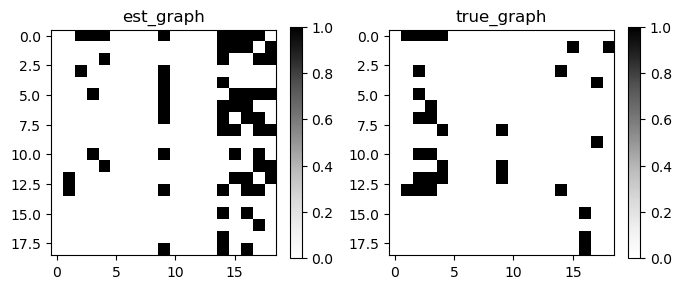

{'fdr': 0.8033, 'tpr': 0.3871, 'fpr': 0.35, 'shd': 67, 'nnz': 61, 'precision': 0.1967, 'recall': 0.3871, 'F1': 0.2609, 'gscore': 0.0}


In [15]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
                            (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
                            (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
                            (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
                            (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
                            (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
                            (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
                            (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
                            (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
                            (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15)])#,(14,4),(16,17),(16,18)])
# priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

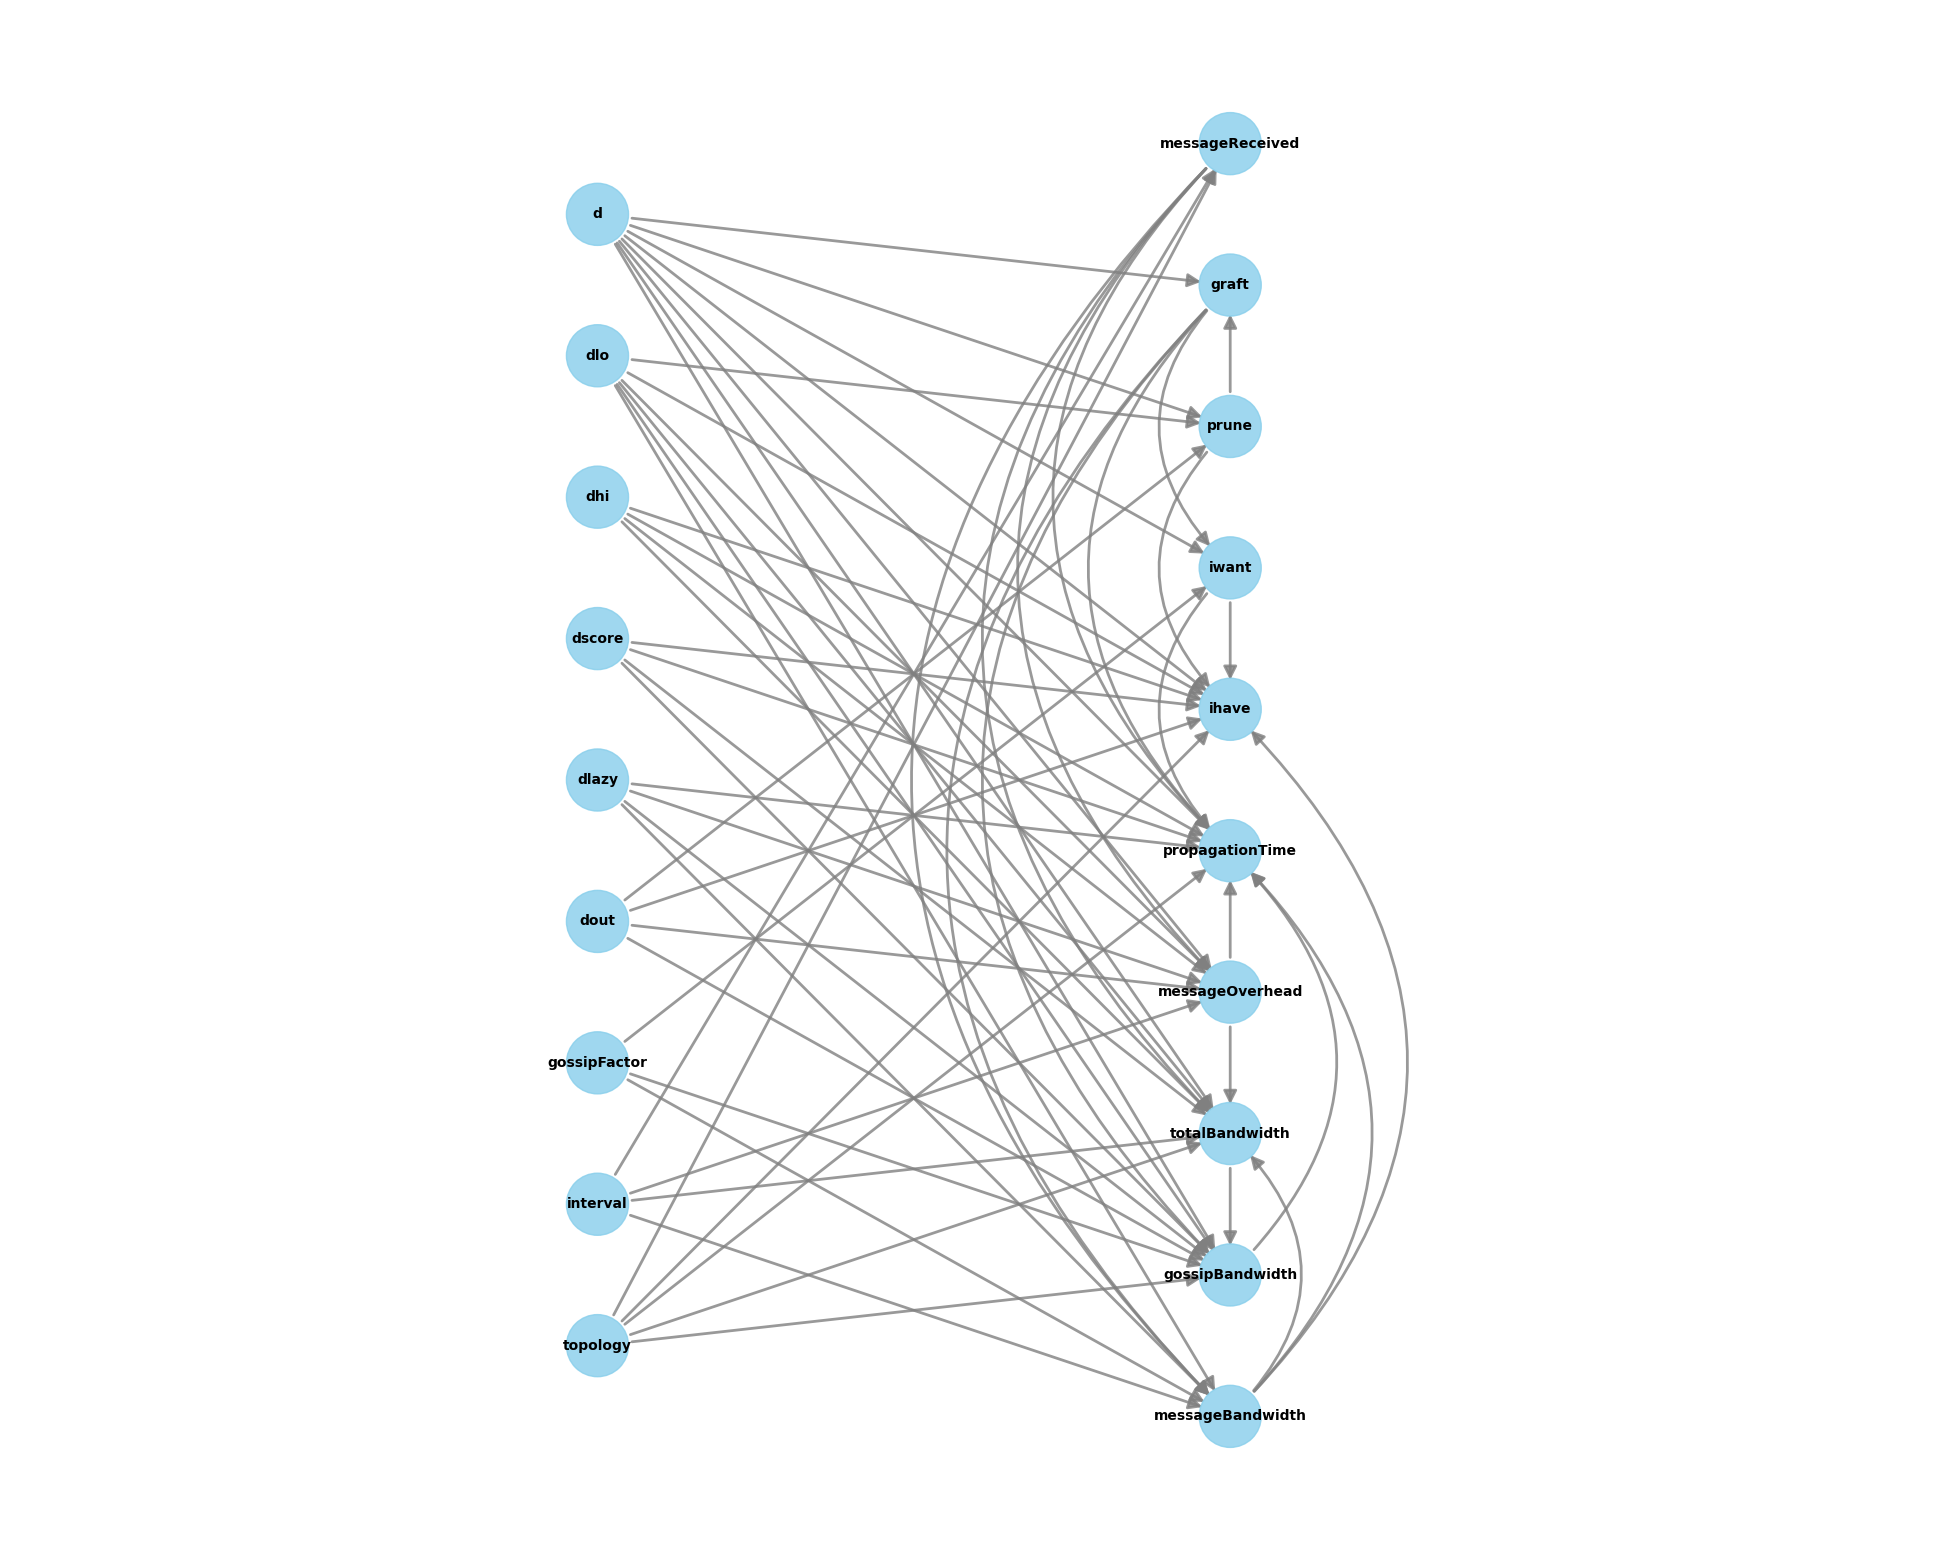

In [16]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'totalBandwidth',
            17:'gossipBandwidth',
            18:'messageBandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab